In [169]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import glob
import re
import os

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)

from tqdm.auto import tqdm, trange

from functools import partial
from collections import OrderedDict

from pathlib import Path

In [179]:
from traffic4cast.data.data_layout import volume_channel_indices
from traffic4cast.data.data_layout import channel_labels
from traffic4cast.data.data_layout import offset_map
from traffic4cast.data.dataset import T4CDataset

from traffic4cast.models.baseline_unet import UNetTransfomer, UNet

from traffic4cast.util.check_data_raw_dir import check_raw_data_dir
from traffic4cast.util.h5_util import load_h5_file

from traffic4cast.metrics.masking import get_static_mask, create_static_mask

from traffic4cast.util.h5_util import load_h5_file
from traffic4cast.util.h5_util import write_data_to_h5

In [5]:
!ls weights_submission

BERLIN_0806_14:25_vanilla_unet_mse_best_val_loss_2019=0.0000_v5.ckpt
CHICAGO_0805_00:38_vanilla_unet_mse_best_val_loss_2019=42.6634.ckpt
ISTANBUL_0805_23:17_vanilla_unet_mse_best_val_loss_2019=0.0000_v4.ckpt
MELBOURNE_0804_19:42_vanilla_unet_mse_best_val_loss_2019=26.7588.ckpt
berlin_weights.zip
chicago_weights.zip
istanbul_weights.zip
melbourne_weights.zip


In [16]:
berlin_weights = 'weights_submission/BERLIN_0806_14:25_vanilla_unet_mse_best_val_loss_2019=0.0000_v5.ckpt'
chicago_weights = 'weights_submission/CHICAGO_0805_00:38_vanilla_unet_mse_best_val_loss_2019=42.6634.ckpt'
istanbul_weights = 'weights_submission/ISTANBUL_0805_23:17_vanilla_unet_mse_best_val_loss_2019=0.0000_v4.ckpt'
melbourne_weights = 'weights_submission/MELBOURNE_0804_19:42_vanilla_unet_mse_best_val_loss_2019=26.7588.ckpt'

In [202]:
berlin_static_map = '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/BERLIN/BERLIN_static.h5'
chicago_static_map = '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/CHICAGO/CHICAGO_static.h5'
istanbul_static_map = '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/ISTANBUL/ISTANBUL_static.h5'
melbourne_static_map = '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/MELBOURNE/MELBOURNE_static.h5'

In [183]:
berlin_static_gen_map = "/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast-maps/BERLIN_combined_static.h5"
chicago_static_gen_map = "/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast-maps/CHICAGO_combined_static.h5"
istanbul_static_gen_map = "/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast-maps/ISTANBUL_combined_static.h5"
melbourne_static_gen_map = "/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast-maps/MELBOURNE_combined_static.h5"

In [69]:
def load_state_dict_from_lightning_checkpoint_(model: nn.Module, path: str, ):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    lightning_state_dict = checkpoint['state_dict']

    try:
        model.load_state_dict(lightning_state_dict)
    except RuntimeError as e:
        print(e)
        print("    Atttempting loading with keys renaming: ")
        
        new_state_dict = OrderedDict()
        
        for key in lightning_state_dict.keys():
            sep_index = key.find(".")
            new_state_dict[key[sep_index + 1:]] = lightning_state_dict[key]
            
        model.load_state_dict(new_state_dict)
        
        print("    Success! ")

In [79]:
dataset_path = '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/'
city = 'MELBOURNE'
n_splits = 4
val_fold_idx = 0

model_path = melbourne_weights

In [80]:
val_2019_dataset = T4CDataset(
    root_dir=dataset_path,
    file_filter=f"{city}/training/2019*8ch.h5",
    transform=partial(UNetTransfomer.unet_pre_transform,
                      stack_channels_on_time=True,
                      zeropad2d=(6, 6, 1, 0), batch_dim=False),
    n_splits=n_splits,
    folds_to_use=tuple([val_fold_idx])
    if val_fold_idx is not None else None,
)

In [81]:
model = UNet(
    in_channels=12 * 8,
    n_classes=6 * 8,
    depth=5,
    wf=6,
    padding=True,
    up_mode="upconv",
    batch_norm=True
)

load_state_dict_from_lightning_checkpoint_(model, model_path)

model.eval()

Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down_path.0.block.0.weight", "down_path.0.block.0.bias", "down_path.0.block.2.weight", "down_path.0.block.2.bias", "down_path.0.block.2.running_mean", "down_path.0.block.2.running_var", "down_path.0.block.3.weight", "down_path.0.block.3.bias", "down_path.0.block.5.weight", "down_path.0.block.5.bias", "down_path.0.block.5.running_mean", "down_path.0.block.5.running_var", "down_path.1.block.0.weight", "down_path.1.block.0.bias", "down_path.1.block.2.weight", "down_path.1.block.2.bias", "down_path.1.block.2.running_mean", "down_path.1.block.2.running_var", "down_path.1.block.3.weight", "down_path.1.block.3.bias", "down_path.1.block.5.weight", "down_path.1.block.5.bias", "down_path.1.block.5.running_mean", "down_path.1.block.5.running_var", "down_path.2.block.0.weight", "down_path.2.block.0.bias", "down_path.2.block.2.weight", "down_path.2.block.2.bias", "down_path.2.block.2.running_mean", "down_path.2.block.2.running

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): 

In [83]:
for i in trange(len(val_2019_dataset)):
    inp, y_true = val_2019_dataset[i]
    
    y_hat = model(inp.unsqueeze(0))
    
    print(y_hat.shape)
    print(y_true.shape)
    
    loss_value = F.mse_loss(y_hat.squeeze(0), y_true)
    
    print(loss_value)
    
#     break

  0%|          | 0/10800 [00:00<?, ?it/s]

torch.Size([1, 48, 496, 448])
torch.Size([48, 496, 448])
tensor(7.0984, grad_fn=<MseLossBackward>)
torch.Size([1, 48, 496, 448])
torch.Size([48, 496, 448])
tensor(7.5730, grad_fn=<MseLossBackward>)
torch.Size([1, 48, 496, 448])
torch.Size([48, 496, 448])
tensor(6.9234, grad_fn=<MseLossBackward>)
torch.Size([1, 48, 496, 448])
torch.Size([48, 496, 448])
tensor(6.6921, grad_fn=<MseLossBackward>)
torch.Size([1, 48, 496, 448])
torch.Size([48, 496, 448])
tensor(6.6583, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [84]:
inp, y_true = val_2019_dataset[1240]

y_hat = model(inp.unsqueeze(0))

print(y_hat.shape)
print(y_true.shape)

loss_value = F.mse_loss(y_hat.squeeze(0), y_true)

print(loss_value)


torch.Size([1, 48, 496, 448])
torch.Size([48, 496, 448])
tensor(6.1961, grad_fn=<MseLossBackward>)


In [125]:
y_hat_numpy = np.clip(y_hat.data.numpy()[0], 0, 255)
y_true_numpy = y_true.data.numpy()

In [127]:
np.unique(y_hat_numpy)

array([0.0000000e+00, 3.7252903e-09, 4.6566129e-09, ..., 8.7243568e+01,
       1.0273417e+02, 1.3878065e+02], dtype=float32)

In [128]:
np.unique(y_true_numpy)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 15

In [129]:
y_hat_numpy.dtype

dtype('float32')

In [130]:
y_true_numpy.dtype

dtype('float32')

In [131]:
y_hat_numpy[6]

array([[0.0027125 , 0.00810551, 0.01153028, ..., 0.0014144 , 0.00436196,
        0.01742898],
       [0.00267448, 0.        , 0.00048781, ..., 0.        , 0.        ,
        0.00997048],
       [0.00202811, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00696848],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00136941],
       [0.0063658 , 0.0026567 , 0.00098536, ..., 0.        , 0.        ,
        0.00640529],
       [0.01151532, 0.01060956, 0.00722576, ..., 0.00596594, 0.00576419,
        0.01563409]], dtype=float32)

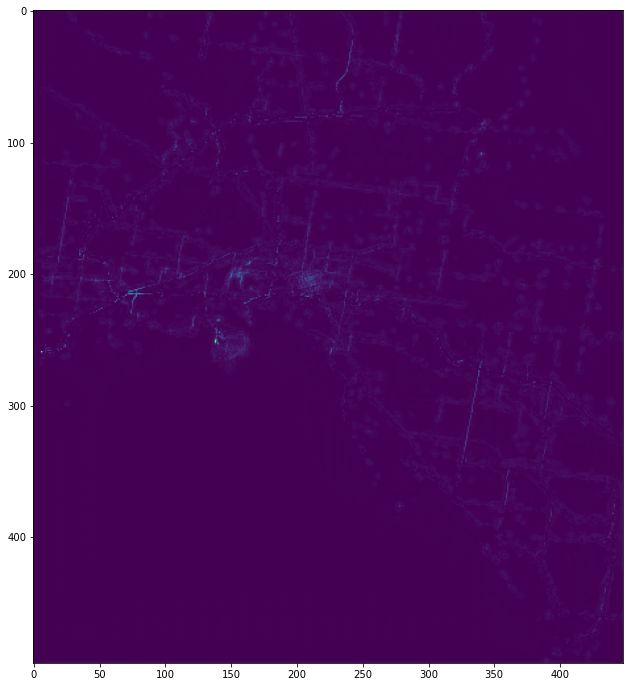

In [132]:
plt.imshow(y_hat_numpy[6])
plt.show()

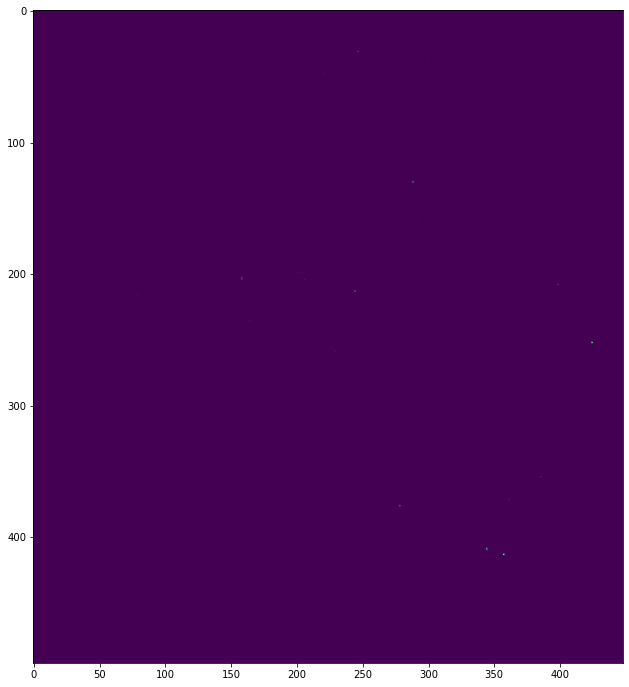

In [133]:
plt.imshow(y_true_numpy[6])
plt.show()

In [ ]:
# submit

In [136]:
competition_files = glob.glob(f"{dataset_path}/**/*test_temporal.h5", recursive=True)

In [137]:
competition_files

['/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/MELBOURNE/MELBOURNE_test_temporal.h5',
 '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/CHICAGO/CHICAGO_test_temporal.h5',
 '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/ISTANBUL/ISTANBUL_test_temporal.h5',
 '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/BERLIN/BERLIN_test_temporal.h5']

In [139]:
import argparse
import datetime
import glob
import logging
import os
import re
import shutil
import tempfile
import zipfile
from pathlib import Path
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Union

In [ ]:
dataset_path = '/Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/'
city = 'MELBOURNE'
n_splits = 4
val_fold_idx = 0

model_path = melbourne_weights

In [184]:
CITY_TO_WEIGHTS = {
    "MELBOURNE": melbourne_weights,
    "ISTANBUL": istanbul_weights,
    "CHICAGO": chicago_weights,
    "BERLIN": berlin_weights,
}

CITY_TO_MODEL = {}

In [203]:
CITY_TO_MASK_PATHS = {
    "MELBOURNE": melbourne_static_map,
    "ISTANBUL": istanbul_static_map,
    "CHICAGO": chicago_static_map,
    "BERLIN": berlin_static_map,
}

CITY_TO_GEN_MASK_PATHS = {
    "MELBOURNE": melbourne_static_gen_map,
    "ISTANBUL": istanbul_static_gen_map,
    "CHICAGO": chicago_static_gen_map,
    "BERLIN": berlin_static_gen_map,
}

In [185]:
for city in CITY_TO_WEIGHTS.keys():
    
    print(f"  Loading model for {city}..")
    
    model = UNet(
        in_channels=12 * 8,
        n_classes=6 * 8,
        depth=5,
        wf=6,
        padding=True,
        up_mode="upconv",
        batch_norm=True
    )
    
    weights_path = CITY_TO_WEIGHTS[city]
    
    load_state_dict_from_lightning_checkpoint_(model, weights_path)
    
    print(f"  done loading model for {city}..")
    
    CITY_TO_MODEL[city] = model

  Loading model for MELBOURNE..
Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down_path.0.block.0.weight", "down_path.0.block.0.bias", "down_path.0.block.2.weight", "down_path.0.block.2.bias", "down_path.0.block.2.running_mean", "down_path.0.block.2.running_var", "down_path.0.block.3.weight", "down_path.0.block.3.bias", "down_path.0.block.5.weight", "down_path.0.block.5.bias", "down_path.0.block.5.running_mean", "down_path.0.block.5.running_var", "down_path.1.block.0.weight", "down_path.1.block.0.bias", "down_path.1.block.2.weight", "down_path.1.block.2.bias", "down_path.1.block.2.running_mean", "down_path.1.block.2.running_var", "down_path.1.block.3.weight", "down_path.1.block.3.bias", "down_path.1.block.5.weight", "down_path.1.block.5.bias", "down_path.1.block.5.running_mean", "down_path.1.block.5.running_var", "down_path.2.block.0.weight", "down_path.2.block.0.bias", "down_path.2.block.2.weight", "down_path.2.block.2.bias", "down_path.2.block.2.running_mea

Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down_path.0.block.0.weight", "down_path.0.block.0.bias", "down_path.0.block.2.weight", "down_path.0.block.2.bias", "down_path.0.block.2.running_mean", "down_path.0.block.2.running_var", "down_path.0.block.3.weight", "down_path.0.block.3.bias", "down_path.0.block.5.weight", "down_path.0.block.5.bias", "down_path.0.block.5.running_mean", "down_path.0.block.5.running_var", "down_path.1.block.0.weight", "down_path.1.block.0.bias", "down_path.1.block.2.weight", "down_path.1.block.2.bias", "down_path.1.block.2.running_mean", "down_path.1.block.2.running_var", "down_path.1.block.3.weight", "down_path.1.block.3.bias", "down_path.1.block.5.weight", "down_path.1.block.5.bias", "down_path.1.block.5.running_mean", "down_path.1.block.5.running_var", "down_path.2.block.0.weight", "down_path.2.block.0.bias", "down_path.2.block.2.weight", "down_path.2.block.2.bias", "down_path.2.block.2.running_mean", "down_path.2.block.2.running

Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down_path.0.block.0.weight", "down_path.0.block.0.bias", "down_path.0.block.2.weight", "down_path.0.block.2.bias", "down_path.0.block.2.running_mean", "down_path.0.block.2.running_var", "down_path.0.block.3.weight", "down_path.0.block.3.bias", "down_path.0.block.5.weight", "down_path.0.block.5.bias", "down_path.0.block.5.running_mean", "down_path.0.block.5.running_var", "down_path.1.block.0.weight", "down_path.1.block.0.bias", "down_path.1.block.2.weight", "down_path.1.block.2.bias", "down_path.1.block.2.running_mean", "down_path.1.block.2.running_var", "down_path.1.block.3.weight", "down_path.1.block.3.bias", "down_path.1.block.5.weight", "down_path.1.block.5.bias", "down_path.1.block.5.running_mean", "down_path.1.block.5.running_var", "down_path.2.block.0.weight", "down_path.2.block.0.bias", "down_path.2.block.2.weight", "down_path.2.block.2.bias", "down_path.2.block.2.running_mean", "down_path.2.block.2.running

Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "down_path.0.block.0.weight", "down_path.0.block.0.bias", "down_path.0.block.2.weight", "down_path.0.block.2.bias", "down_path.0.block.2.running_mean", "down_path.0.block.2.running_var", "down_path.0.block.3.weight", "down_path.0.block.3.bias", "down_path.0.block.5.weight", "down_path.0.block.5.bias", "down_path.0.block.5.running_mean", "down_path.0.block.5.running_var", "down_path.1.block.0.weight", "down_path.1.block.0.bias", "down_path.1.block.2.weight", "down_path.1.block.2.bias", "down_path.1.block.2.running_mean", "down_path.1.block.2.running_var", "down_path.1.block.3.weight", "down_path.1.block.3.bias", "down_path.1.block.5.weight", "down_path.1.block.5.bias", "down_path.1.block.5.running_mean", "down_path.1.block.5.running_var", "down_path.2.block.0.weight", "down_path.2.block.0.bias", "down_path.2.block.2.weight", "down_path.2.block.2.bias", "down_path.2.block.2.running_mean", "down_path.2.block.2.running

In [217]:
def package_submission(
    data_raw_path: str,
    competition: str,
    model_str: str,
    model: Union[torch.nn.Module, Dict[str, torch.nn.Module]],
    device: str,
    submission_output_dir: Path,
    batch_size=10,
    num_tests_per_file=100,
    h5_compression_params: dict = None,
    city_masks_path: Optional[dict] = None,
    **additional_transform_args,
) -> Path:
    tstamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d%H%M")

    if h5_compression_params is None:
        h5_compression_params = {}

    if submission_output_dir is None:
        submission_output_dir = Path(".")
    submission_output_dir.mkdir(exist_ok=True, parents=True)
    submission = submission_output_dir / f"submission_{model_str}_{competition}_{tstamp}.zip"
    print(submission)

    competition_files = glob.glob(f"{data_raw_path}/**/*test_{competition}.h5", recursive=True)

    assert len(competition_files) > 0

    model_dict = None
    if isinstance(model, dict):
        model_dict = model

    with tempfile.TemporaryDirectory() as temp_dir:
        with zipfile.ZipFile(submission, "w") as z:
            for competition_file in competition_files:
                print(f"  running model on {competition_file}")
                city = re.search(r".*/([A-Z]+)_test_", competition_file).group(1)
                
                if model_dict is not None:
                    print(f'   loading model for {city}')
                    model = model_dict[city]
                model = model.to(device)
                model.eval()

                pre_transform: Callable[[np.ndarray], Union[torch.Tensor, torch_geometric.data.Data]] = \
                    partial(UNetTransfomer.unet_pre_transform, 
                            stack_channels_on_time=True, zeropad2d=(6, 6, 1, 0), 
                            batch_dim=True, from_numpy=True)
                    
                post_transform: Callable[[Union[torch.Tensor, torch_geometric.data.Data]], np.ndarray] = \
                    partial(UNetTransfomer.unet_post_transform, 
                            stack_channels_on_time=True, crop=(6, 6, 1, 0), batch_dim=True)
                    
                if city_masks_path is not None:
                    mask_path = city_masks_path[city]
                    city_mask = load_h5_file(mask_path)
                
                    mask_torch = torch.from_numpy(city_mask)

                    if mask_torch.shape[0] > mask_torch.shape[2]:
                        mask_torch = torch.moveaxis(mask_torch, 2, 0)

                    mask_torch_unsqueezed = torch.unsqueeze(mask_torch, 0)

                    zeropad2d = (6, 6, 1, 0) # TODO: move to config
                    if zeropad2d is not None:
                        padding = torch.nn.ZeroPad2d(zeropad2d)
                        mask_torch_unsqueezed = padding(mask_torch_unsqueezed)

                    summed_mask = torch.sum(mask_torch_unsqueezed[0], dim=0)
                    mask_2d = torch.where(summed_mask > 0, 1, 0)
                    
                    print(f"    loaded city mask with shape: {mask_2d.shape}")
                    
                assert num_tests_per_file % batch_size == 0, f"num_tests_per_file={num_tests_per_file} must be a multiple of batch_size={batch_size}"

                num_batches = num_tests_per_file // batch_size
                prediction = np.zeros(shape=(num_tests_per_file, 6, 495, 436, 8), dtype=np.uint8)

                with torch.no_grad():
                    for i in trange(num_batches):
                        batch_start = i * batch_size
                        batch_end = batch_start + batch_size
                        test_data: np.ndarray = load_h5_file(competition_file, sl=slice(batch_start, batch_end), to_torch=False)
                        additional_data = load_h5_file(competition_file.replace("test", "test_additional"), sl=slice(batch_start, batch_end), to_torch=False)

                        if pre_transform is not None:
                            test_data: Union[torch.Tensor, torch_geometric.data.Data] = pre_transform(test_data, city=city, **additional_transform_args)
                        else:
                            test_data = torch.from_numpy(test_data)
                            test_data = test_data.to(dtype=torch.float)
                        test_data = test_data.to(device)
                        
                        additional_data = torch.from_numpy(additional_data)
                        additional_data = additional_data.to(device)
                        
                        batch_prediction = model(test_data, city=city, additional_data=additional_data)
                        
                        if mask_2d is not None:
#                             print(torch.count_nonzero(batch_prediction))
                            batch_prediction = batch_prediction * mask_2d
#                             print(torch.count_nonzero(batch_prediction))

                        if post_transform is not None:
                            batch_prediction = post_transform(batch_prediction, city=city, **additional_transform_args)
                        else:
                            batch_prediction = batch_prediction.cpu().detach().numpy()
                        batch_prediction = np.clip(batch_prediction, 0, 255)
                        # clipping is important as assigning float array to uint8 array has not the intended effect.... (see `test_submission.test_assign_reload_floats)
                        
                        prediction[batch_start:batch_end] = batch_prediction
                        
                        
                unique_values = np.unique(prediction)
                print(f"  {len(unique_values)} unique values in prediction in the range [{np.min(prediction)}, {np.max(prediction)}]")
                
#                 plt.hist(prediction.flatten())
#                 plt.show()

                temp_h5 = os.path.join(temp_dir, os.path.basename(competition_file))
                arcname = os.path.join(*competition_file.split(os.sep)[-2:])
                print(f"  writing h5 file {temp_h5}")
                
                write_data_to_h5(prediction, temp_h5, **h5_compression_params)
                print(f"  adding {temp_h5} as {arcname}")
                
                z.write(temp_h5, arcname=arcname)
                
            print(z.namelist())
            
    submission_mb_size = os.path.getsize(submission) / (1024 * 1024)
    print(f"Submission {submission} with {submission_mb_size:.2f}MB")

    return submission

In [181]:
# submit basic unet

package_submission(
    data_raw_path= dataset_path,
    competition = 'temporal',
    model_str = 'baseline_unet',
    model = CITY_TO_MODEL,
    device = 'cpu',
    submission_output_dir = Path('submission/'),
    batch_size=1,
    num_tests_per_file=100,
    h5_compression_params = {"compression_level": 6},
) 

submission/submission_baseline_unet_temporal_202108110314.zip
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/MELBOURNE/MELBOURNE_test_temporal.h5
   loading model for MELBOURNE


  0%|          | 0/100 [00:00<?, ?it/s]

  254 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/MELBOURNE_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/MELBOURNE_test_temporal.h5 as MELBOURNE/MELBOURNE_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/CHICAGO/CHICAGO_test_temporal.h5
   loading model for CHICAGO


  0%|          | 0/100 [00:00<?, ?it/s]

  242 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/CHICAGO_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/CHICAGO_test_temporal.h5 as CHICAGO/CHICAGO_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/ISTANBUL/ISTANBUL_test_temporal.h5
   loading model for ISTANBUL


  0%|          | 0/100 [00:00<?, ?it/s]

  239 unique values in prediction in the range [0, 239]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/ISTANBUL_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/ISTANBUL_test_temporal.h5 as ISTANBUL/ISTANBUL_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/BERLIN/BERLIN_test_temporal.h5
   loading model for BERLIN


  0%|          | 0/100 [00:00<?, ?it/s]

  256 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/BERLIN_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpmvwd1ekv/BERLIN_test_temporal.h5 as BERLIN/BERLIN_test_temporal.h5
['MELBOURNE/MELBOURNE_test_temporal.h5', 'CHICAGO/CHICAGO_test_temporal.h5', 'ISTANBUL/ISTANBUL_test_temporal.h5', 'BERLIN/BERLIN_test_temporal.h5']
Submission submission/submission_baseline_unet_temporal_202108110314.zip with 271.88MB


PosixPath('submission/submission_baseline_unet_temporal_202108110314.zip')

In [218]:
# submit unet + provided static masks

package_submission(
    data_raw_path= dataset_path,
    competition = 'temporal',
    model_str = 'baseline_unet_static_masked',
    model = CITY_TO_MODEL,
    device = 'cpu',
    submission_output_dir = Path('submission/'),
    batch_size=1,
    num_tests_per_file=100,
    h5_compression_params = {"compression_level": 6},
    city_masks_path = CITY_TO_MASK_PATHS,
) 

submission/submission_baseline_unet_static_masked_temporal_202108110416.zip
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/MELBOURNE/MELBOURNE_test_temporal.h5
   loading model for MELBOURNE
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  254 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/MELBOURNE_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/MELBOURNE_test_temporal.h5 as MELBOURNE/MELBOURNE_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/CHICAGO/CHICAGO_test_temporal.h5
   loading model for CHICAGO
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  242 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/CHICAGO_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/CHICAGO_test_temporal.h5 as CHICAGO/CHICAGO_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/ISTANBUL/ISTANBUL_test_temporal.h5
   loading model for ISTANBUL
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  239 unique values in prediction in the range [0, 239]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/ISTANBUL_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/ISTANBUL_test_temporal.h5 as ISTANBUL/ISTANBUL_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/BERLIN/BERLIN_test_temporal.h5
   loading model for BERLIN
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  256 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/BERLIN_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpkita1mo3/BERLIN_test_temporal.h5 as BERLIN/BERLIN_test_temporal.h5
['MELBOURNE/MELBOURNE_test_temporal.h5', 'CHICAGO/CHICAGO_test_temporal.h5', 'ISTANBUL/ISTANBUL_test_temporal.h5', 'BERLIN/BERLIN_test_temporal.h5']
Submission submission/submission_baseline_unet_static_masked_temporal_202108110416.zip with 268.72MB


PosixPath('submission/submission_baseline_unet_static_masked_temporal_202108110416.zip')

In [222]:
# submit unet + generated static masks

package_submission(
    data_raw_path= dataset_path,
    competition = 'temporal',
    model_str = 'baseline_unet_generated_masked',
    model = CITY_TO_MODEL,
    device = 'cpu',
    submission_output_dir = Path('submission/'),
    batch_size=1,
    num_tests_per_file=100,
    h5_compression_params = {"compression_level": 6},
    city_masks_path = CITY_TO_GEN_MASK_PATHS,
) 

submission/submission_baseline_unet_generated_masked_temporal_202108110519.zip
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/MELBOURNE/MELBOURNE_test_temporal.h5
   loading model for MELBOURNE
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  254 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/MELBOURNE_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/MELBOURNE_test_temporal.h5 as MELBOURNE/MELBOURNE_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/CHICAGO/CHICAGO_test_temporal.h5
   loading model for CHICAGO
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  242 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/CHICAGO_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/CHICAGO_test_temporal.h5 as CHICAGO/CHICAGO_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/ISTANBUL/ISTANBUL_test_temporal.h5
   loading model for ISTANBUL
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  239 unique values in prediction in the range [0, 239]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/ISTANBUL_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/ISTANBUL_test_temporal.h5 as ISTANBUL/ISTANBUL_test_temporal.h5
  running model on /Users/Vsevolod.Konyakhin/Desktop/data/traffic4cast/BERLIN/BERLIN_test_temporal.h5
   loading model for BERLIN
    loaded city mask with shape: torch.Size([496, 448])


  0%|          | 0/100 [00:00<?, ?it/s]

  256 unique values in prediction in the range [0, 255]
  writing h5 file /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/BERLIN_test_temporal.h5
  adding /var/folders/59/0g32rt9d059ft90c5w294szr0000kt/T/tmpxlcwshhv/BERLIN_test_temporal.h5 as BERLIN/BERLIN_test_temporal.h5
['MELBOURNE/MELBOURNE_test_temporal.h5', 'CHICAGO/CHICAGO_test_temporal.h5', 'ISTANBUL/ISTANBUL_test_temporal.h5', 'BERLIN/BERLIN_test_temporal.h5']
Submission submission/submission_baseline_unet_generated_masked_temporal_202108110519.zip with 271.72MB


PosixPath('submission/submission_baseline_unet_generated_masked_temporal_202108110519.zip')